# Train Model

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model Imports
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Scikit-learn Tools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Hyperparameter Tuning & Experiment Tracking
import optuna
import mlflow

# Save Model
import joblib

# To silent CatBoost and Optuna output during tuning
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Load Data

In [20]:
df_train = pd.read_csv("../data/processed/train.csv")
df_test = pd.read_csv("../data/processed/test.csv")

In [21]:
X_train = df_train.drop('HeartDisease', axis=1)
y_train = df_train['HeartDisease']

X_test = df_test.drop('HeartDisease', axis=1)
y_test = df_test['HeartDisease']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (734, 11)
Test data shape: (184, 11)


In [4]:
def objective(trial, model_name):  
    """
    Objective function for Optuna to optimize.
    It suggests hyperparameters, creates a model, and evaluates it using cross-validation.
    """
    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
 
    # --- Define Hyperparameter Search Space for each model ---

    if model_name == 'RandomForest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'random_state': 42,
        }
        model = RandomForestClassifier(**params)

    elif model_name == 'XGBoost':
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'use_label_encoder': False,
            'random_state': 42,
        }
        model = XGBClassifier(**params)

    elif model_name == 'LightGBM':
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'random_state': 42,
        }
        model = LGBMClassifier(**params)

    elif model_name == 'CatBoost':
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'random_strength': trial.suggest_float('random_strength', 0.1, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'verbose': 0, # Suppress output
            'random_seed': 42,
        }
        model = CatBoostClassifier(**params)

    # --- Evaluate the model using cross-validation ---
    # We use AUC here as it's a great overall metric for binary classification
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [6]:
# --- 3. Run the Optimization for Each Model ---
models_to_tune = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
best_models = {}
N_TRIALS = 50 # Number of tuning iterations, increase for better results

for model_name in models_to_tune: 
    print(f"🚀 Tuning {model_name}...")
    # Create a study object and optimize the objective function.
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_name), n_trials=N_TRIALS, n_jobs=-1)

    # Store the best trial
    best_models[model_name] = {
        'best_score': study.best_value,
        'best_params': study.best_params
    }
    print(f"✅ Best AUC for {model_name}: {study.best_value:.4f}")
    print("Best parameters found:")
    print(study.best_params)
    print("-" * 30)



🚀 Tuning RandomForest...
✅ Best AUC for RandomForest: 0.9323
Best parameters found:
{'n_estimators': 459, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 4}
------------------------------
🚀 Tuning XGBoost...
✅ Best AUC for XGBoost: 0.9339
Best parameters found:
{'n_estimators': 381, 'learning_rate': 0.14871506238565105, 'max_depth': 8, 'subsample': 0.6255601874050464, 'colsample_bytree': 0.9816192529658122, 'gamma': 4.073424692078611}
------------------------------
🚀 Tuning LightGBM...
✅ Best AUC for LightGBM: 0.9309
Best parameters found:
{'n_estimators': 295, 'learning_rate': 0.016532721563430074, 'num_leaves': 250, 'max_depth': 4, 'subsample': 0.9435593627767983, 'colsample_bytree': 0.6440118683341206}
------------------------------
🚀 Tuning CatBoost...
✅ Best AUC for CatBoost: 0.9346
Best parameters found:
{'iterations': 875, 'learning_rate': 0.014452241428143373, 'depth': 5, 'l2_leaf_reg': 4.893738679096699, 'random_strength': 3.14282268758533, 'bagging_temperature':

In [7]:
# --- 4. Compare Models and Select the Best One ---
best_overall_model_name = max(best_models, key=lambda k: best_models[k]['best_score'])
best_overall_params = best_models[best_overall_model_name]['best_params']

print(f"\n🏆 Best overall model is: {best_overall_model_name} with AUC = {best_models[best_overall_model_name]['best_score']:.4f}")


# --- 5. Final Evaluation on the Test Set ---
print("\n--- Final Evaluation on Test Set ---")

# Re-create the best model with the optimal hyperparameters
final_model = None
if best_overall_model_name == 'RandomForest':
    final_model = RandomForestClassifier(**best_overall_params, random_state=42)
elif best_overall_model_name == 'XGBoost':
    final_model = XGBClassifier(**best_overall_params, use_label_encoder=False, random_state=42)
elif best_overall_model_name == 'LightGBM':
    final_model = LGBMClassifier(**best_overall_params, random_state=42)
elif best_overall_model_name == 'CatBoost':
    final_model = CatBoostClassifier(**best_overall_params, verbose=0, random_seed=42)

# Train the final model on the ENTIRE training set
final_model.fit(X_train, y_train)

# Make predictions on the held-out test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# --- Print Final Metrics ---
print(f"Final Test AUC: {roc_auc_score(y_test, y_pred_proba):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


🏆 Best overall model is: CatBoost with AUC = 0.9346

--- Final Evaluation on Test Set ---
Final Test AUC: 0.9310

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

Confusion Matrix:
[[70 12]
 [ 9 93]]


## Model Training with MLflow

In [42]:
mlflow.end_run()

In [43]:
# Set up MLflow experiment
mlflow.set_experiment("Heart Diseases Classification Experiment")

<Experiment: artifact_location='file:///C:/Users/Christian/Programming_Project/heart-failure-prediction/notebooks/mlruns/378168478397997392', creation_time=1753882125288, experiment_id='378168478397997392', last_update_time=1753882125288, lifecycle_stage='active', name='Heart Diseases Classification Experiment', tags={}>

In [36]:
# Objective Function for Optuna & MLflow
def objective(trial, model_name):
    """Objective function to tune hyperparameters and log results to MLflow."""
    # Start an MLflow run for each trial
    with mlflow.start_run(nested=True):
        mlflow.set_tag("model_name", model_name)
        
        # Define hyperparameter search space (same as before)
        if model_name == 'RandomForest':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'random_state': 42,
            }
            model = RandomForestClassifier(**params)
        elif model_name == 'XGBoost':
            params = {
                'objective': 'binary:logistic', 'eval_metric': 'auc',
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'use_label_encoder': False, 'random_state': 42,
            }
            model = XGBClassifier(**params)
        elif model_name == 'LightGBM':
            params = {
                'objective': 'binary', 'metric': 'auc', 'verbosity': -1,
                'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'num_leaves': trial.suggest_int('num_leaves', 20, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'random_state': 42,
            }
            model = LGBMClassifier(**params)
        elif model_name == 'CatBoost':
            params = {
                'iterations': trial.suggest_int('iterations', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'depth': trial.suggest_int('depth', 3, 10),
                'verbose': 0, 'random_seed': 42,
            }
            model = CatBoostClassifier(**params)
        
        # Log parameters to MLflow
        mlflow.log_params(params)
        
        # Evaluate using cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
        
        # Log the score to MLflow
        mlflow.log_metric("mean_cv_auc", score)
        
    return score

In [37]:
# Run Optimization and Store Results
models_to_tune = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
best_models = {}
N_TRIALS = 50

for model_name in models_to_tune:
    with mlflow.start_run(run_name=f"Tuning_{model_name}", description=f"Optimizing {model_name} with Optuna"):
        print(f"Tuning {model_name}...")
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, model_name), n_trials=N_TRIALS)
        
        best_models[model_name] = {
            'best_score': study.best_value,
            'best_params': study.best_params,
            'study': study
        }
        mlflow.log_metric("best_cv_auc", study.best_value)
        mlflow.log_params(study.best_params)
        print(f"Best CV AUC for {model_name}: {study.best_value:.4f}")
        print("-" * 30)

Tuning RandomForest...
Best CV AUC for RandomForest: 0.9327
------------------------------
Tuning XGBoost...
Best CV AUC for XGBoost: 0.9366
------------------------------
Tuning LightGBM...
Best CV AUC for LightGBM: 0.9223
------------------------------
Tuning CatBoost...
Best CV AUC for CatBoost: 0.9364
------------------------------



🏆 Best overall model is: XGBoost

--- Training and Evaluating Final Model ---


C:\Users\Christian\Programming_Project\heart-failure-prediction\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:22:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/07/30 19:22:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final Model: XGBoost
Test AUC: 0.9283
Test Recall: 0.9118
Test F1-Score: 0.9029

Final model, metrics, and artifacts logged to MLflow.


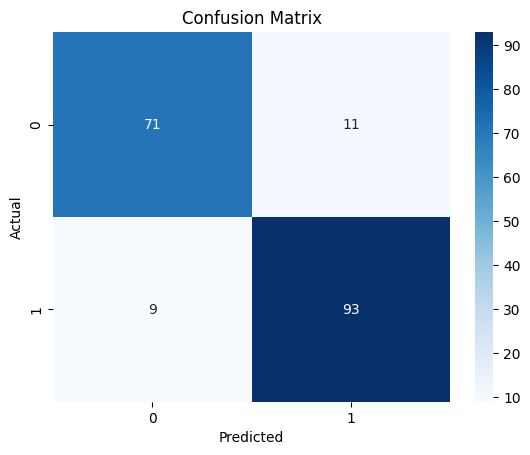

In [38]:
# Select Best Model and Log Final Results
best_overall_model_name = max(best_models, key=lambda k: best_models[k]['best_score'])
best_params = best_models[best_overall_model_name]['best_params']
print(f"\nBest overall model is: {best_overall_model_name}")

# Log the final, best model and its test performance in a new run
with mlflow.start_run(run_name="Final_Best_Model"):
    print("\n--- Training and Evaluating Final Model ---")
    
    # Create the model with the best parameters
    if best_overall_model_name == 'RandomForest':
        final_model = RandomForestClassifier(**best_params, random_state=42)
    elif best_overall_model_name == 'XGBoost':
        final_model = XGBClassifier(**best_params, use_label_encoder=False, random_state=42)
    elif best_overall_model_name == 'LightGBM':
        final_model = LGBMClassifier(**best_params, random_state=42)
    else: # CatBoost
        final_model = CatBoostClassifier(**best_params, verbose=0, random_seed=42)

    # Train on the full training data
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]

    # Calculate final metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    
    # Log parameters, metrics, and tags to MLflow
    mlflow.set_tag("best_model", best_overall_model_name)
    mlflow.log_params(best_params)
    mlflow.log_metrics({
        "test_auc": test_auc,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1_score": test_f1
    })

    # Log the confusion matrix as an image artifact
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    mlflow.log_figure(fig, "confusion_matrix.png")
    
    # Log the model artifact
    mlflow.sklearn.log_model(final_model, name=best_overall_model_name)
    
    print(f"Final Model: {best_overall_model_name}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print("\nFinal model, metrics, and artifacts logged to MLflow.")

## Save Best Model as Joblib file

In [14]:
# Save the trained model to a file
joblib.dump(final_model, "../models/final_model.joblib")
print("Model saved to final_model.joblib")

Model saved to final_model.joblib


In [62]:
print(study)

# Evaluate Model

## Load Model

In [51]:
# test loaded model
loaded_model = joblib.load("../models/final_model1.joblib")

# The model is ready to be used for predictions
#loaded_model.fit(X_train, y_train)

y_pred = loaded_model.predict(X_test)
y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

# Calculate final metrics
test_auc = roc_auc_score(y_test, y_pred_proba)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

2025/07/30 20:37:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final Model: XGBoost
Test AUC: 0.9273
Test Recall: 0.9020
Test F1-Score: 0.8976

Final model, metrics, and artifacts logged to MLflow.


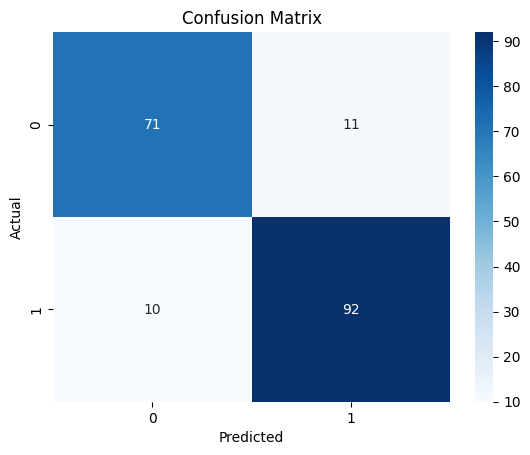

In [52]:
best_overall_model_name = max(best_models, key=lambda k: best_models[k]['best_score'])
best_params = best_models[best_overall_model_name]['best_params']
print(f"\nBest overall model is: {best_overall_model_name}")

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
mlflow.log_figure(fig, "confusion_matrix.png")
    
# Log the model artifact
mlflow.sklearn.log_model(final_model)
    
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print("\nFinal model, metrics, and artifacts logged to MLflow.")

## Evalaute best each model 

In [22]:
import json
with open("../models/best_model_params.json", 'r') as json_file:
        model_params = json.load(json_file)

In [23]:
model_params

{'RandomForest': {'best_score': 0.9325892936733045,
  'best_params': {'n_estimators': 401,
   'max_depth': 19,
   'min_samples_split': 15,
   'min_samples_leaf': 2}},
 'XGBoost': {'best_score': 0.9330114570764977,
  'best_params': {'n_estimators': 173,
   'learning_rate': 0.04871240256000477,
   'max_depth': 8,
   'subsample': 0.8787525478490608,
   'colsample_bytree': 0.624173840041361}},
 'LightGBM': {'best_score': 0.9236771298559916,
  'best_params': {'n_estimators': 260,
   'learning_rate': 0.29787935011822375,
   'num_leaves': 181,
   'max_depth': 9}},
 'CatBoost': {'best_score': 0.9358578207900701,
  'best_params': {'iterations': 363,
   'learning_rate': 0.011185036449472064,
   'depth': 5}}}

In [24]:
for model_param in model_params.keys():
    print(model_params[model_param]['best_params'])
    print()

{'n_estimators': 401, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 2}

{'n_estimators': 173, 'learning_rate': 0.04871240256000477, 'max_depth': 8, 'subsample': 0.8787525478490608, 'colsample_bytree': 0.624173840041361}

{'n_estimators': 260, 'learning_rate': 0.29787935011822375, 'num_leaves': 181, 'max_depth': 9}

{'iterations': 363, 'learning_rate': 0.011185036449472064, 'depth': 5}



Final Model: RandomForest
Test AUC: 0.9258
Test Recall: 0.9216
Test F1-Score: 0.8952
Final Model: XGBoost
Test AUC: 0.9330
Test Recall: 0.8725
Test F1-Score: 0.8856
[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Info] Start training from score 0.213340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

C:\Users\Christian\Programming_Project\heart-failure-prediction\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:11:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

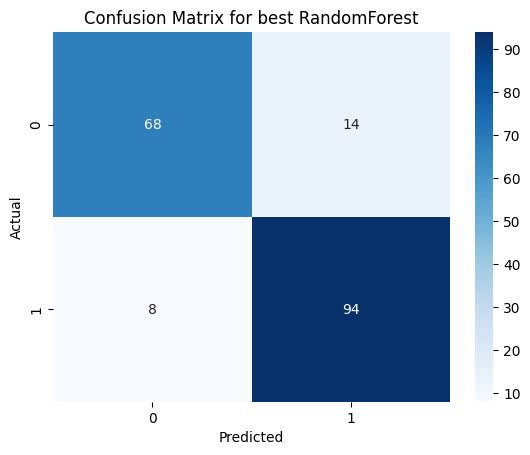

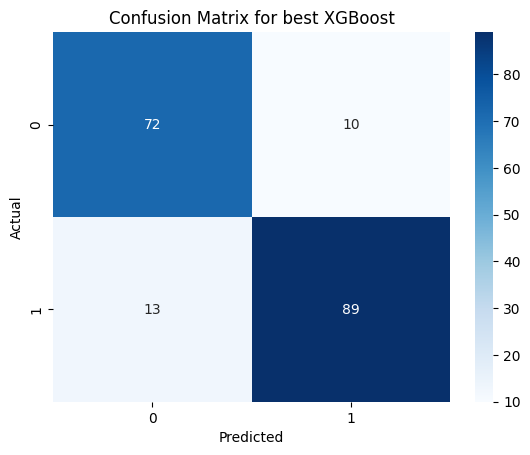

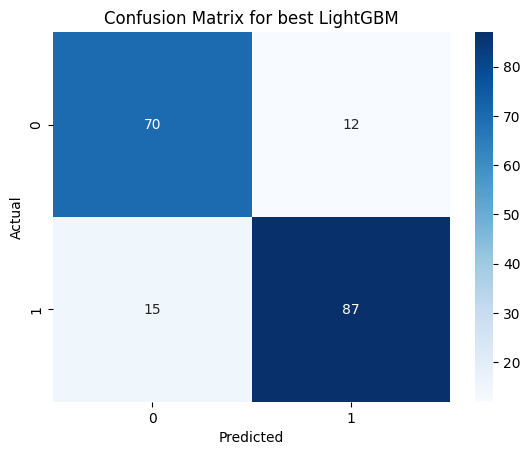

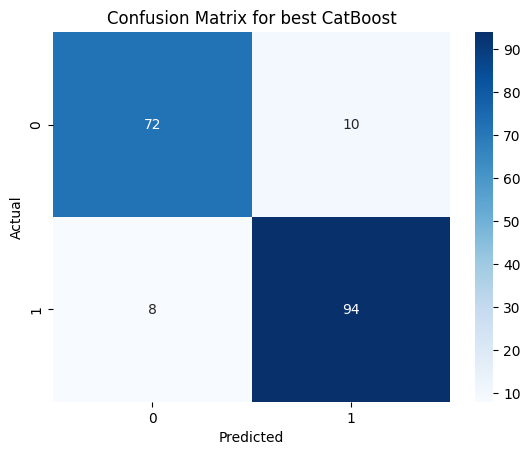

In [27]:
for model in model_params.keys():
    #print(model_params[model_param]['best_params'])
    best_params = model_params[model]['best_params']
    
    if model == 'RandomForest':
        final_model = RandomForestClassifier(**best_params, random_state=42)
    elif model == 'XGBoost':
        final_model = XGBClassifier(**best_params, use_label_encoder=False, random_state=42)
    elif model == 'LightGBM':
        final_model = LGBMClassifier(**best_params, random_state=42)
    else: # CatBoost
        final_model = CatBoostClassifier(**best_params, verbose=0, random_seed=42)

    # Train on the full training data
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]

    # Calculate final metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)

    # Log the confusion matrix as an image artifact
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for best {model}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    mlflow.log_figure(fig, "confusion_matrix.png")
    
    # Log the model artifact
    #mlflow.sklearn.log_model(final_model, name=best_overall_model_name)
    
    print(f"Final Model: {model}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    #print("\nFinal model, metrics, and artifacts logged to MLflow.")

# Predict Model

In [39]:
loaded_model = joblib.load("../models/final_model.joblib")

In [43]:
df_column = pd.read_csv("../data/raw/heart.csv").drop("HeartDisease", axis=1)

In [44]:
df_column

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up
...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat


In [47]:
column_list = df_column.columns.to_list()
print(column_list)

['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


In [74]:
import pandas as pd
import numpy as np
import joblib
import yaml
import os

def load_config(config_path="../config.yaml"):
    with open(config_path) as f:
        return yaml.safe_load(f)

def predict_new_data(model, input_data: pd.DataFrame):
    # Create a copy to avoid modifying the original DataFrame
    data = input_data.copy()
    

    # Preprocessing Steps
    # Features Encoding
    data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
    data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 1, 'N': 0})
    data['ST_Slope'] = data['ST_Slope'].map({'Down': 0, 'Flat': 1, 'Up': 2})
    data['ChestPainType'] = data['ChestPainType'].map({'ASY': 0, 'NAP': 1, 'ATA': 2, 'TA': 3})
    data['RestingECG'] = data['RestingECG'].map({'Normal': 0, 'ST': 1, 'LVH': 2})

    # expected_columns = column_list
    # data = data[expected_columns]

    # --- Make Prediction ---
    prediction = model.predict(data)[0]
    probability = model.predict_proba(data)[0]

    return prediction, probability

if __name__ == "__main__":
    # Load the configuration
    config = load_config()

    # Create Sample New Data for Prediction
    # This dictionary represents a single new patient.
    # The keys must match the original column names.
    new_patient_data = {
        'Age': 58,
        'Sex': 'M',
        'ChestPainType': 'ATA',
        'RestingBP': 136,
        'Cholesterol': 319, # Using a non-zero value
        'FastingBS': 0,
        'RestingECG': 'ST',
        'MaxHR': 152,
        'ExerciseAngina': 'N',
        'Oldpeak': 0.0,
        'ST_Slope': 'Up'
    }

    # Convert the dictionary to a DataFrame
    input_df = pd.DataFrame([new_patient_data])

    # load model
    loaded_model = joblib.load(f"../{config['model']['output_path']}")
    
    # Get the prediction
    prediction, probability = predict_new_data(loaded_model, input_df)

    # --- Display the Result ---
    if prediction is not None:
        print("\n--- Prediction Result ---")
        print(f"Input Data:\n{input_df.to_string(index=False)}")
        print("-" * 25)
        print(f"Predicted Class: {prediction} ({'Heart Disease' if prediction == 1 else 'Normal'})")
        print(f"Prediction Probability (0: Normal, 1: Heart Disease): {probability}")


--- Prediction Result ---
Input Data:
 Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope
  58   M           ATA        136          319          0         ST    152              N      0.0       Up
-------------------------
Predicted Class: 0 (Normal)
Prediction Probability (0: Normal, 1: Heart Disease): [0.88569965 0.11430035]
